In [1]:
import os
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Agenda

1. [Data Preparation + Data Exploration (in a short)](#Data_Preparation_Data_Exploration)
2. [Bag of Words](#Bag_of_Words)
3. [TF-IDF](#Tf_Idf)
4. [Word and Sentence Embeddings](#Word_and_Sentance_Embeddings)
5. [Create Validation and build first model](#Validation)
6. [Homework](#Homework)

# Resources
- https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/code?datasetId=572515
- https://github.com/udsclub/udscourse
- https://www.kaggle.com/code/paramarthasengupta/fake-news-detector-eda-prediction-99
- https://scikit-learn.org/stable/modules/feature_extraction.html
- https://spacy.io/
- https://radimrehurek.com/gensim/
- https://www.sbert.net/
- https://www.sbert.net/docs/usage/semantic_textual_similarity.html
- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<a id='Data_Preparation_Data_Exploration'></a>
# Data Preparation + Data Exploration

## Load 

In [2]:
os.listdir("../data/fake-and-real-news-dataset/")

['Fake.csv', 'True.csv']

In [3]:
fake = pd.read_csv("../data/fake-and-real-news-dataset/Fake.csv")
true = pd.read_csv("../data/fake-and-real-news-dataset/True.csv")

## Initial Exploration

In [4]:
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [5]:
true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [6]:
fake.iloc[0].to_dict()

{'title': ' Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing',
 'text': 'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year

In [7]:
true.iloc[0].to_dict()

{'title': 'As U.S. budget fight looms, Republicans flip their fiscal script',
 'text': 'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proporti

## Merge tables

In [8]:
true['target'] = 1
fake['target'] = 0
df = pd.concat([true, fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  target  \
0  December 31, 2017        1   
1  December 29, 2017        1   
2  December 31, 2017        1   
3  December 30, 2017        1   
4  December 29, 2017        1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

## Explore Columns

In [9]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

In [10]:
df["target"].value_counts()

0    23481
1    21417
Name: target, dtype: int64

In [11]:
df["subject"].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [12]:
for subject in df.subject.unique():
    print(subject, '\n', df[df['subject'] == subject]['target'].value_counts(), '\n')

politicsNews 
 1    11272
Name: target, dtype: int64 

worldnews 
 1    10145
Name: target, dtype: int64 

News 
 0    9050
Name: target, dtype: int64 

politics 
 0    6841
Name: target, dtype: int64 

Government News 
 0    1570
Name: target, dtype: int64 

left-news 
 0    4459
Name: target, dtype: int64 

US_News 
 0    783
Name: target, dtype: int64 

Middle-east 
 0    778
Name: target, dtype: int64 



In [13]:
# Transforming the unmatching subjects to the same notation
df["subject"] = df["subject"].replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})
df["subject"].value_counts()

PoliticsNews       18113
worldnews          10145
News                9050
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [14]:
df["date"]

0        December 31, 2017 
1        December 29, 2017 
2        December 31, 2017 
3        December 30, 2017 
4        December 29, 2017 
                ...        
44893      January 16, 2016
44894      January 16, 2016
44895      January 15, 2016
44896      January 14, 2016
44897      January 12, 2016
Name: date, Length: 44898, dtype: object

<AxesSubplot: xlabel='date', ylabel='target'>

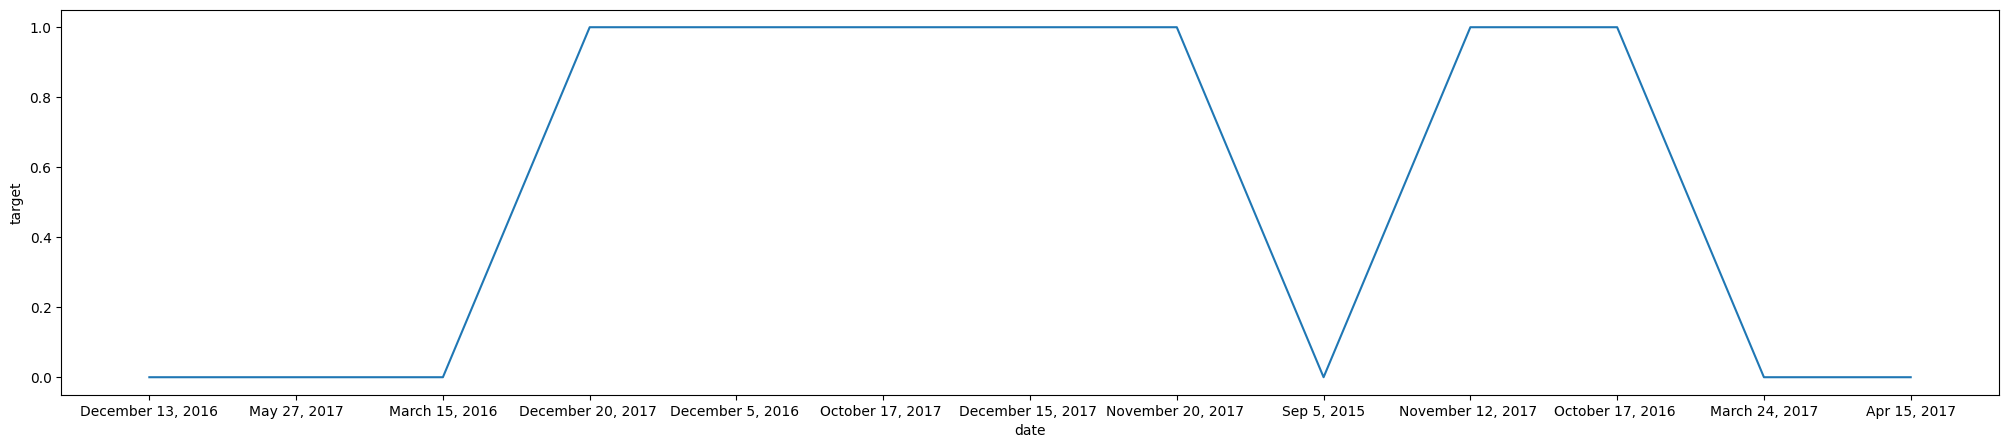

In [15]:
import seaborn as sns
plt.figure(figsize=(25, 5))
sns.lineplot(x = "date", y = "target",
             data = df.sample(13))

In [16]:
month_name_2_number = {calendar.month_name[number]:str(number) for number in range(1, 13)}
month_abbr_2_number = {calendar.month_abbr[number]:str(number) for number in range(1, 13)}

def convert_to_datetime_format(input):
    try:
        if "-" in input:
            d, m, y = input.split("-")
            y = "20" + y
        else:
            m, d, y = input.split()
        # Exclude `,`
        d = d[:-1]
        if m in month_name_2_number:
            m = month_name_2_number[m] 
        else:
            m = month_abbr_2_number[m]
        return f"{d}/{m}/{y}"
    except Exception as e:
        print(f"convert_to_datetime_format Failed on {input}. With Exception : {e}")
        return None
    
df["date"] = df["date"].apply(convert_to_datetime_format)
df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True)

df["date"]

convert_to_datetime_format Failed on https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/. With Exception : too many values to unpack (expected 3)
convert_to_datetime_format Failed on https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/. With Exception : too many values to unpack (expected 3)
convert_to_datetime_format Failed on https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/. With Exception : too many values to unpack (expected 3)
convert_to_datetime_format Failed on https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg. With Exception : not enough values to unpack (expected 3, got 2)
convert_to_datetime_format Failed on https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg. With Exception : not enough values to unpack (expe

0       2017-12-31
1       2017-12-29
2       2017-12-31
3       2017-12-30
4       2017-12-29
           ...    
44893   2016-01-16
44894   2016-01-16
44895   2016-01-15
44896   2016-01-14
44897   2016-01-12
Name: date, Length: 44898, dtype: datetime64[ns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

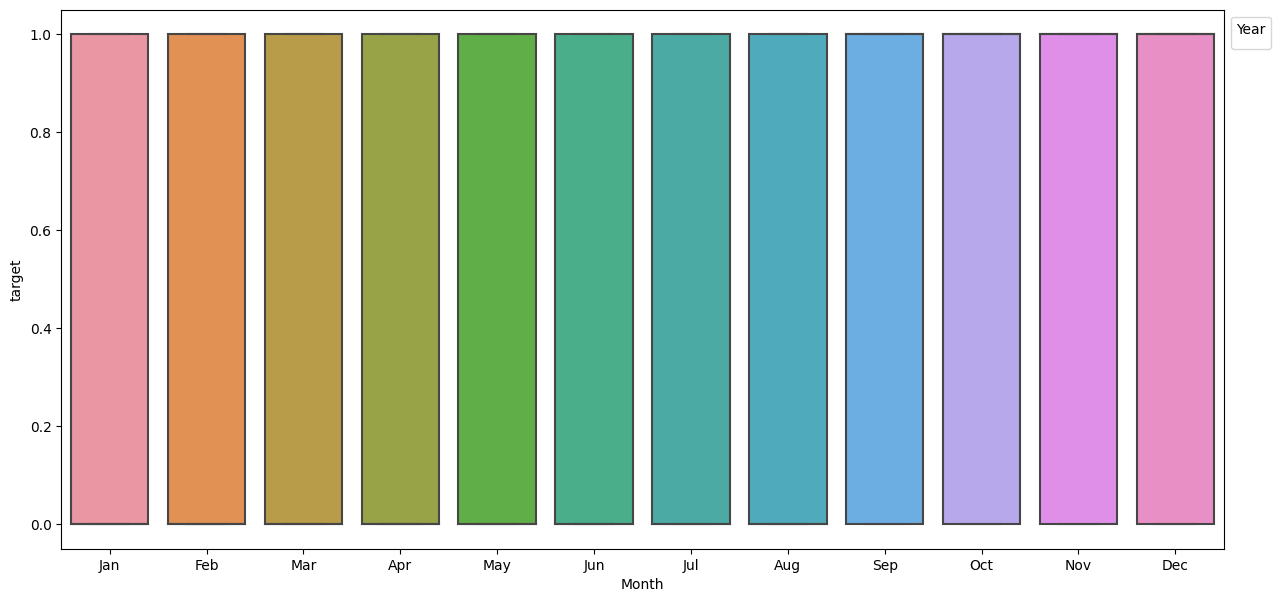

In [17]:
from calendar import month_abbr as months
months = list(months)[1:]

fig, ax = plt.subplots(figsize=(15, 7))

sns.boxplot(x=df.date.dt.month, y=df.target, ax=ax)
ax.legend(title='Year', bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel='Month', xticklabels=months)  # setting the xticklabels is optional
plt.show

/var/folders/8r/80qp0xcx3p986rp4th0s50140000gn/T/ipykernel_6485/3784327834.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlabel='Month', xticklabels=months)  # setting the xticklabels is optional


<function matplotlib.pyplot.show(close=None, block=None)>

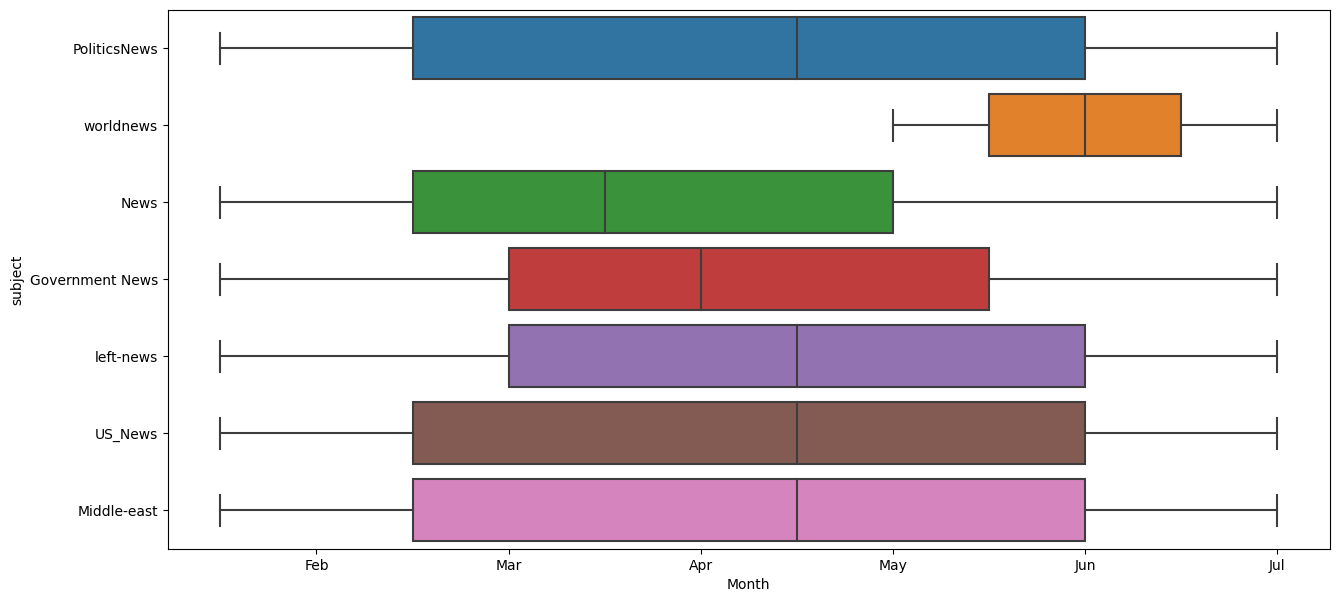

In [18]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.boxplot(x=df.date.dt.month, y=df.subject, ax=ax)
ax.set(xlabel='Month', xticklabels=months)  # setting the xticklabels is optional
plt.show

## Text Preparation

In [19]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            # len(token) > 2 and 
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

In [20]:
idx = 100

print(
    f"Before : {df['title'].iloc[idx]}\n"
    f"After : {preprocess(df['title'].iloc[idx])}"
)

Before : Senator Warren hits out at 'effort to politicize' U.S. consumer agency
After : senator warren hits effort politicize consumer agency


In [21]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_text'] = df['text'].apply(preprocess)
df['clean_original'] = df['original'].apply(preprocess)

## Text Visualisation

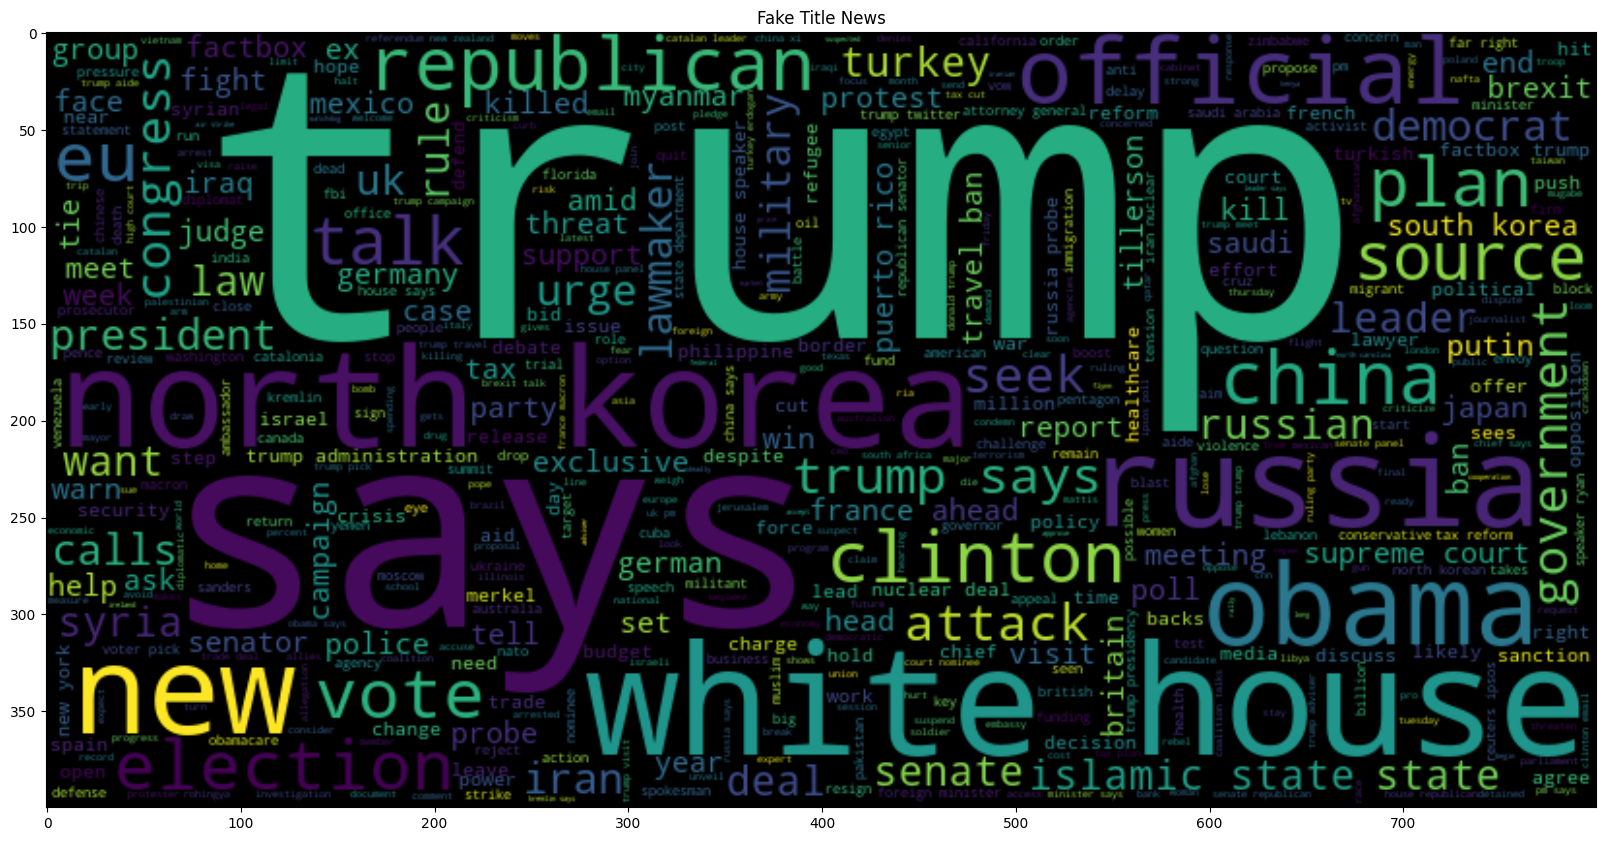

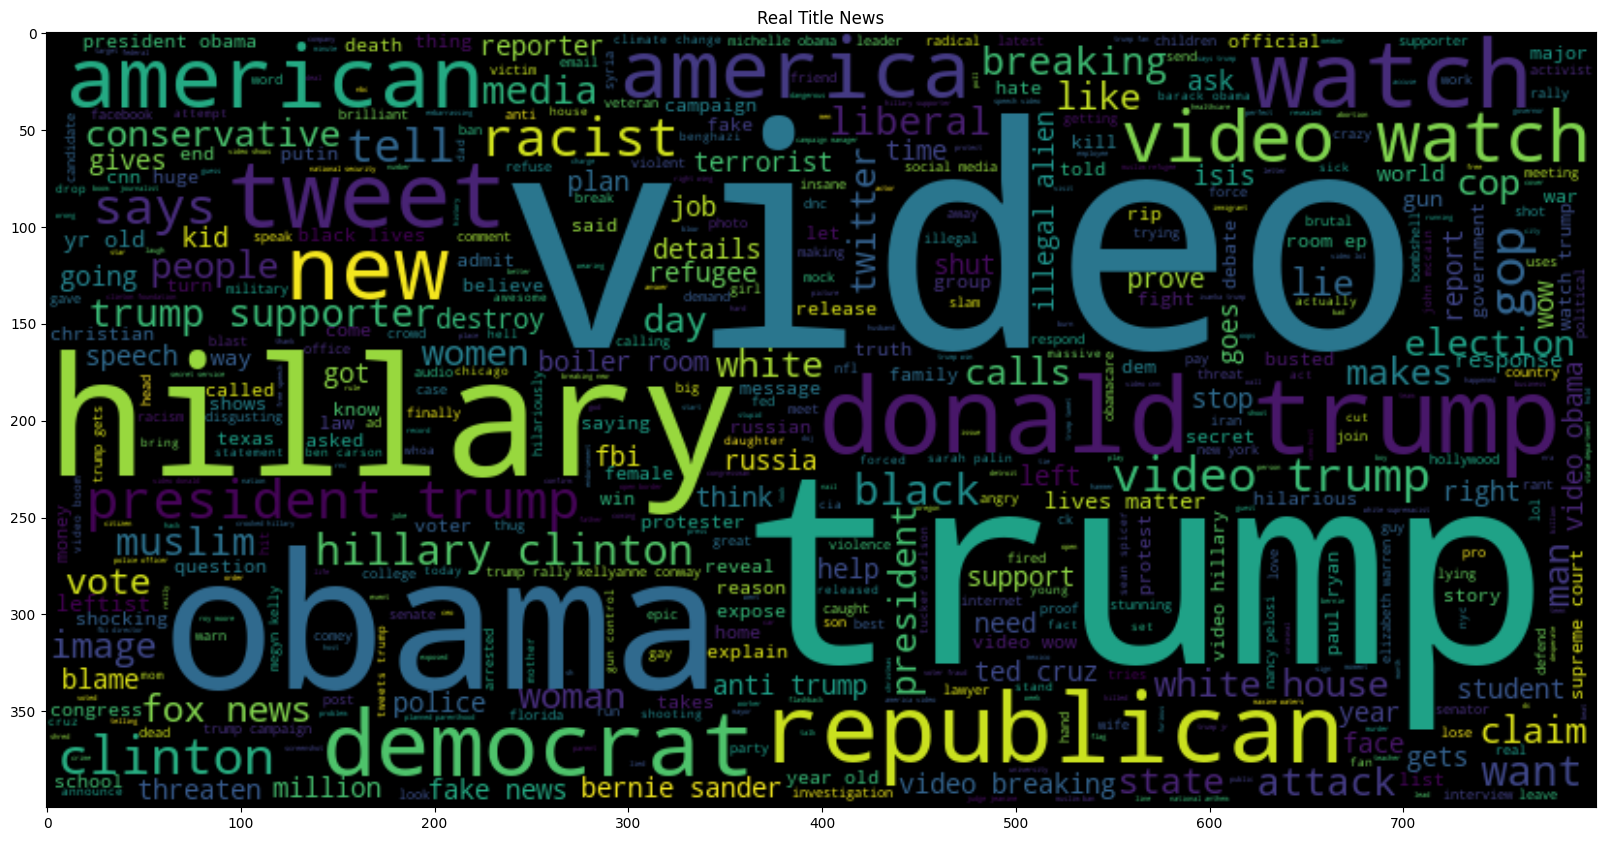

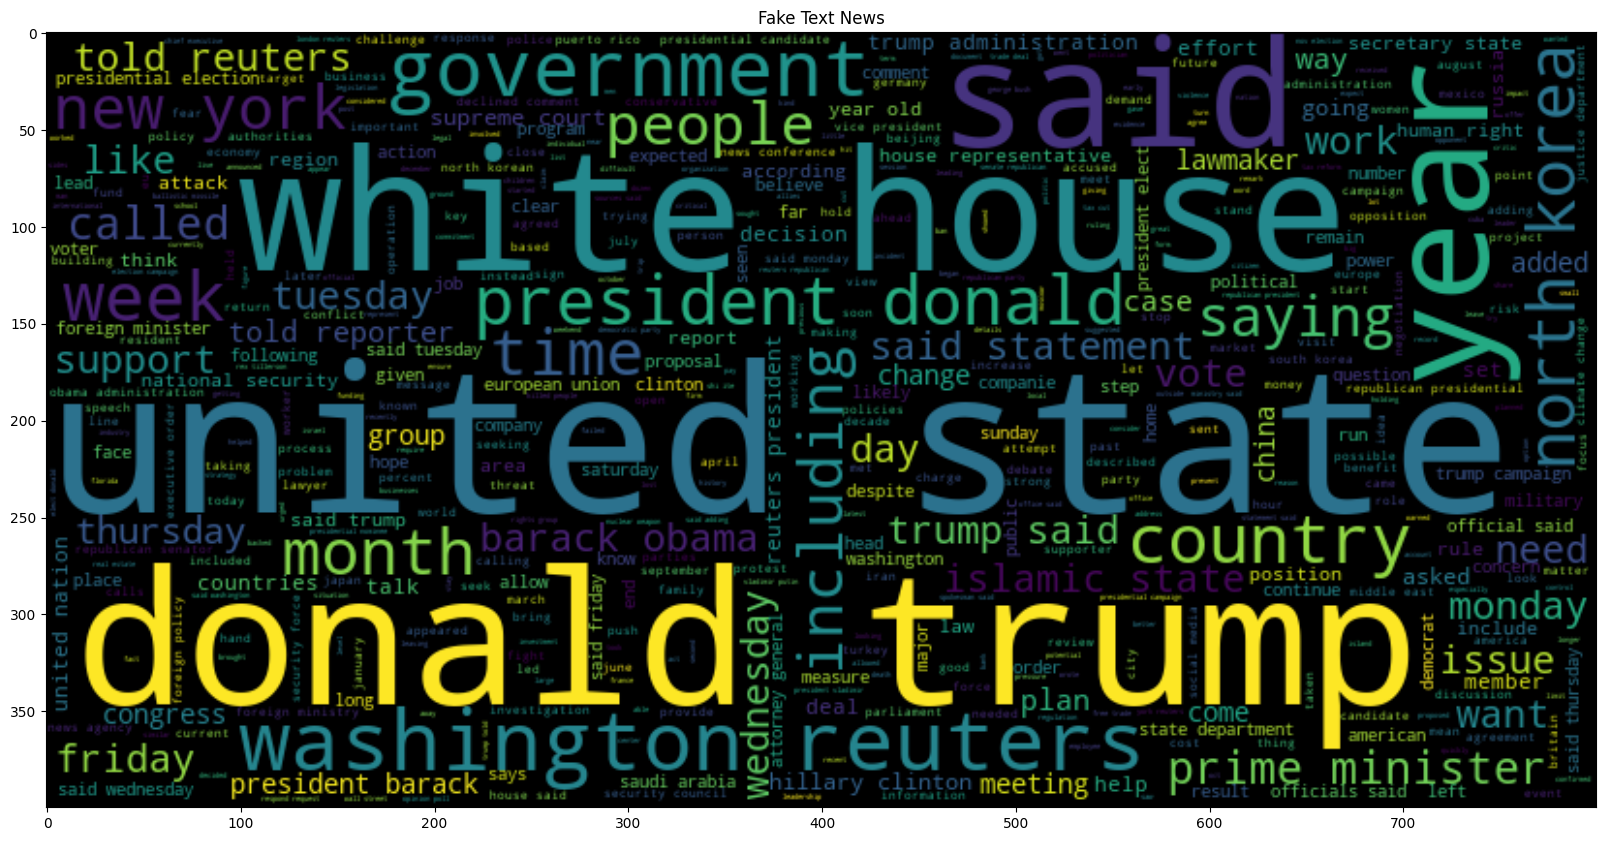

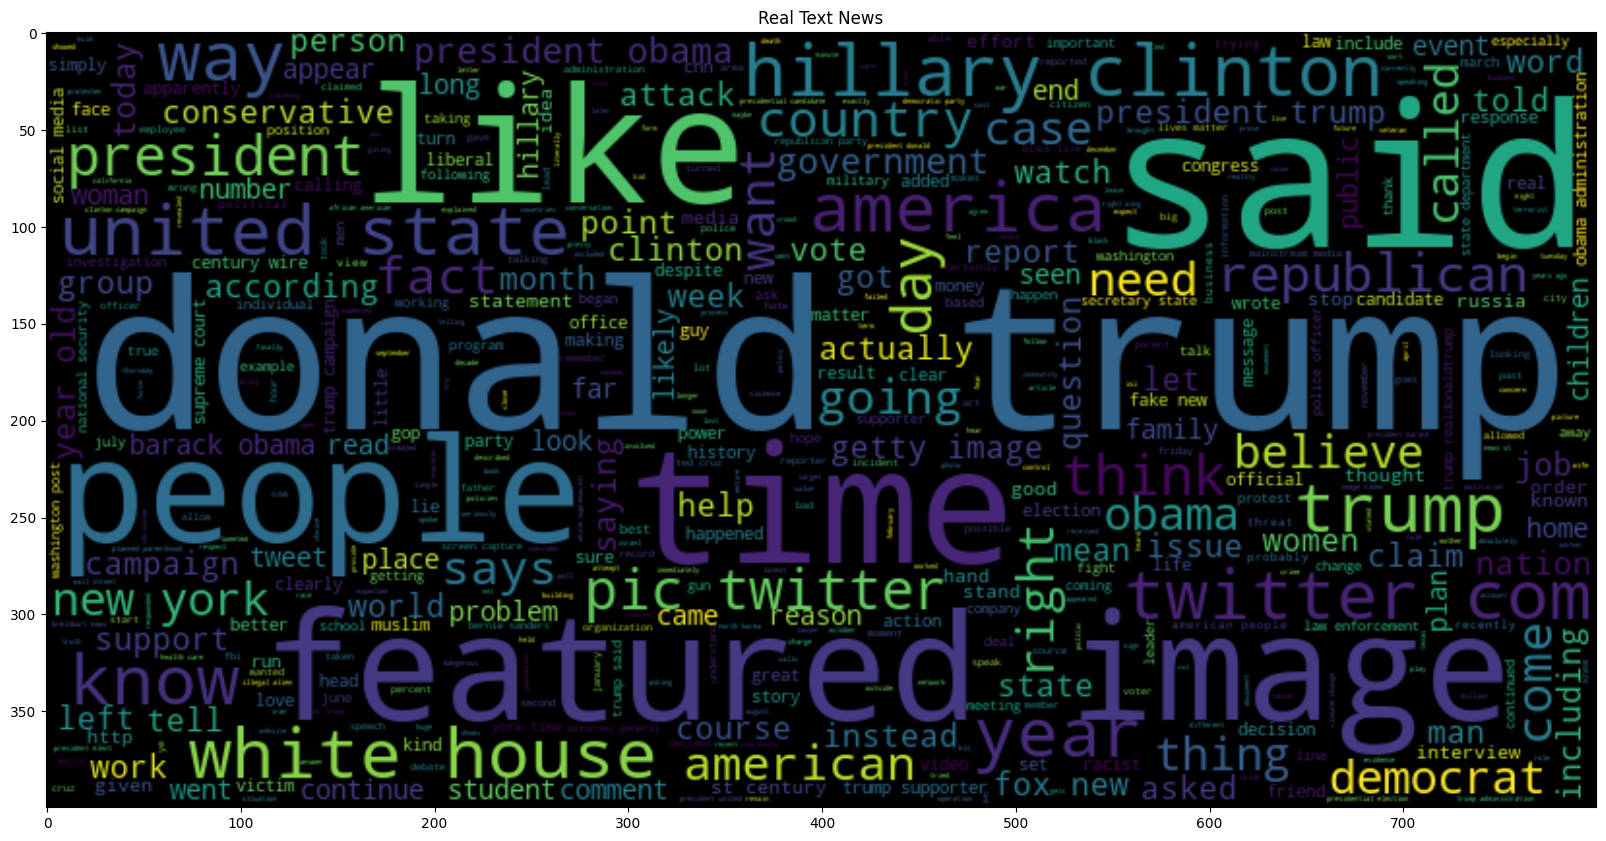

In [22]:
# TODO: Check out https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/code?datasetId=572515&sortBy=voteCount and enlarge EDA with additional text statistics
# Can you find something interesting
# TODO: Also check out this EDA - https://github.com/udsclub/udscourse/blob/master/lectures/1.1%20Pandas%20-%20Toxic%20Comments%20EDA.ipynb and try to apply some ideas to Fake News dataset

plt.figure(figsize = (20,20)) 
plt.title("Fake Title News")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df.target == 1, "clean_title"]))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Real Title News")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df.target == 0, "clean_title"]))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Fake Text News")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df.target == 1, "clean_text"]))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Real Text News")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df.target == 0, "clean_text"]))
plt.imshow(wc, interpolation = 'bilinear')

# How "Translate" Text into Numbers 

![tf-idf](https://habrastorage.org/files/a0a/bb1/2e9/a0abb12e9ed94624ade0b9090d26ad66.png)

<a id='Bag_of_Words'></a>
# [Bag of Words](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)

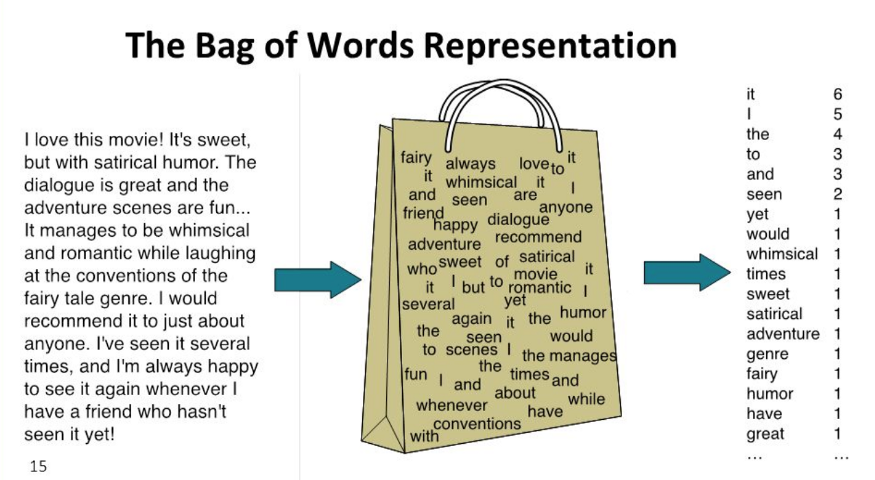

Advantages:
- Simple and Fast solution 
- Highly Explainable 
- ...

Disadvantages:
- Do not take into account token distribution across the corpus
- Arrangment information is lost 
- ...

TODO: Add your thoughts to Advantages/Disadvantages

In [23]:
# TODO: Explore https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer
# Try to use n-grams, stop_words, max_features and other parameters out of the box (without using clean_* columns)

bag_of_words_object = CountVectorizer()
bag_of_words_matrix = bag_of_words_object.fit_transform(
    df["title"].iloc[:10]
)
print(f"Bag of Words: {bag_of_words_object.get_feature_names_out()}")
print(
    f"Text : {df['title'].iloc[0]}\n"
    f"Vectorization: {bag_of_words_object.transform([df['title'].iloc[0]]).toarray()[0]}"
)

Bag of Words: ['28' '29' 'accept' 'alabama' 'amazon' 'approval' 'as' 'australian' 'be'
 'budget' 'but' 'by' 'certify' 'challenge' 'charge' 'cnn' 'congress' 'dec'
 'despite' 'diplomat' 'do' 'elect' 'factbox' 'fair' 'fbi' 'fight' 'fiscal'
 'flip' 'for' 'global' 'helped' 'his' 'house' 'immigration' 'job' 'jones'
 'let' 'looms' 'military' 'monday' 'more' 'mr' 'much' 'mueller' 'nyt'
 'off' 'official' 'on' 'pentagon' 'postal' 'prepare' 'probe' 'rating'
 'recruits' 'republican' 'republicans' 'russia' 'says' 'script' 'senator'
 'senior' 'service' 'shipments' 'spending' 'talks' 'their' 'timeline'
 'tip' 'to' 'today' 'transgender' 'trump' 'twitter' 'unclear' 'wants'
 'warming' 'white' 'will']
Text : As U.S. budget fight looms, Republicans flip their fiscal script
Vectorization: [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0]


In [24]:
bag_of_words_object = CountVectorizer()
bag_of_words_matrix = bag_of_words_object.fit_transform(
    df["clean_title"].iloc[:10]
)
print(f"Bag of Words: {bag_of_words_object.get_feature_names_out()}")
print(
    f"Text : {df['clean_title'].iloc[0]}\n"
    f"Vectorization: {bag_of_words_object.transform([df['clean_title'].iloc[0]]).toarray()[0]}"
)

Bag of Words: ['accept' 'alabama' 'amazon' 'approval' 'australian' 'budget' 'certify'
 'challenge' 'charge' 'cnn' 'congress' 'dec' 'despite' 'diplomat' 'elect'
 'factbox' 'fair' 'fbi' 'fight' 'fiscal' 'flip' 'global' 'helped' 'house'
 'immigration' 'job' 'jones' 'let' 'looms' 'military' 'monday' 'mr'
 'mueller' 'nyt' 'official' 'pentagon' 'postal' 'prepare' 'probe' 'rating'
 'recruits' 'republican' 'republicans' 'russia' 'says' 'script' 'senator'
 'senior' 'service' 'shipments' 'spending' 'talks' 'timeline' 'tip'
 'today' 'transgender' 'trump' 'twitter' 'unclear' 'wants' 'warming'
 'white']
Text : budget fight looms republicans flip fiscal script
Vectorization: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


<a id='Tf_Idf'></a>
# [Tf-Idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)

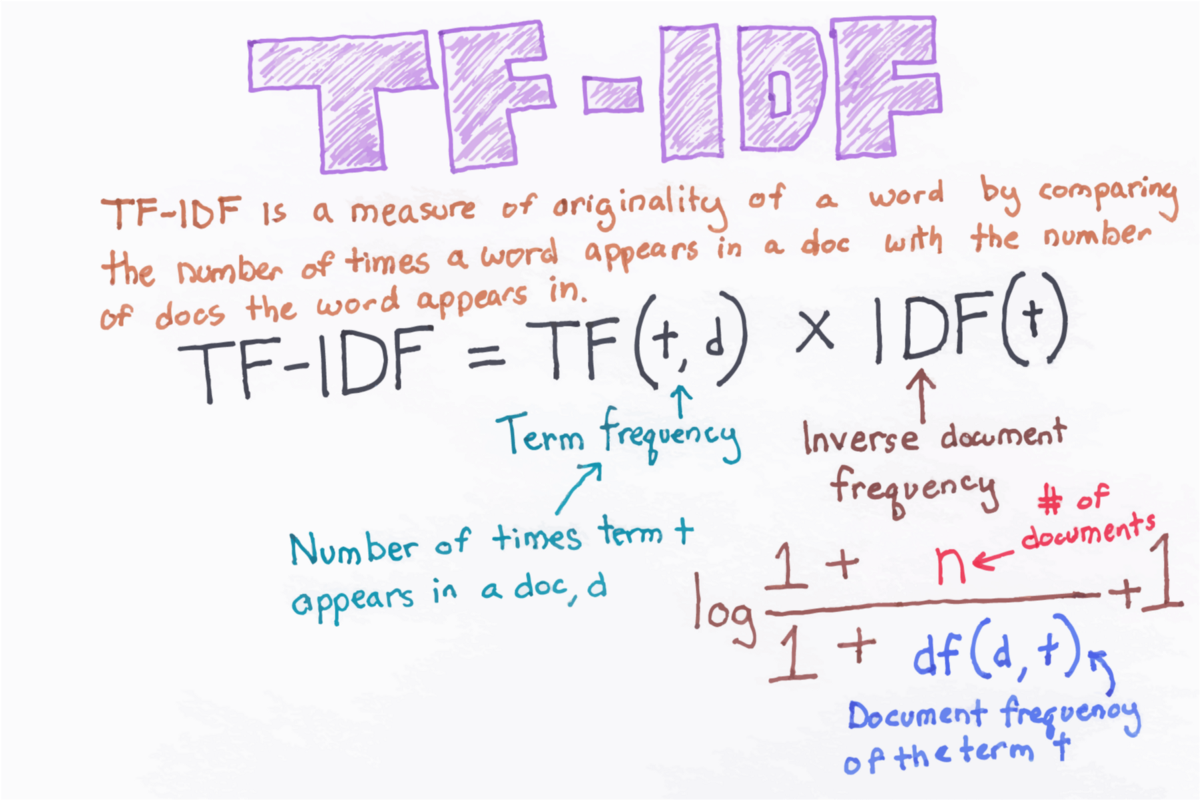

Advantages:
- Simple and Fast solution 
- Highly Explainable 
- Take into account token distribution across the corpus
- ...

Disadvantages:
- Arrangment information is lost 
- ...

TODO: Add your thoughts to Advantages/Disadvantages

In [25]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    df["title"].iloc[:20]
)
print(f"Bag of Words: {tf_idf_object.get_feature_names_out()}")
print(
    f"Text : {df['title'].iloc[1]}\n"
    f"Vectorization: {tf_idf_object.transform([df['title'].iloc[1]]).toarray()[0]}"
)

Bag of Words: ['2016' '26' '27' '28' '29' 'accept' 'alabama' 'amazon' 'appeals'
 'approval' 'as' 'at' 'australian' 'be' 'bill' 'box' 'budget'
 'businessman' 'but' 'by' 'certified' 'certify' 'challenge' 'charge'
 'clinton' 'cnn' 'congress' 'constitutionality' 'court' 'cut' 'dec'
 'decide' 'delivered' 'despite' 'diplomat' 'do' 'drawing' 'elect'
 'election' 'factbox' 'fair' 'fbi' 'federal' 'fight' 'fiscal' 'flip' 'for'
 'fraud' 'gift' 'global' 'governor' 'he' 'helped' 'hillary' 'his' 'horse'
 'house' 'immigration' 'iraq' 'job' 'jones' 'law' 'lawmakers' 'let'
 'looms' 'lottery' 'man' 'manure' 'meeting' 'military' 'mnuchin' 'monday'
 'moore' 'more' 'mr' 'much' 'mueller' 'new' 'nyt' 'of' 'off' 'official'
 'officials' 'on' 'overhaul' 'panel' 'pentagon' 'postal' 'postpone'
 'prepare' 'probe' 'protest' 'question' 'questions' 'rating' 'recruits'
 'rejects' 'reports' 'republican' 'republicans' 'russia' 'says' 'script'
 'secretary' 'senate' 'senator' 'senior' 'sent' 'service' 'shipments'
 'sources

In [26]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    df["title"].iloc[:20]
)
print(f"Bag of Words: {tf_idf_object.get_feature_names_out()}")
print(
    f"Text : {df['clean_title'].iloc[1]}\n"
    f"Vectorization: {tf_idf_object.transform([df['clean_title'].iloc[1]]).toarray()[0]}"
)

Bag of Words: ['2016' '26' '27' '28' '29' 'accept' 'alabama' 'amazon' 'appeals'
 'approval' 'as' 'at' 'australian' 'be' 'bill' 'box' 'budget'
 'businessman' 'but' 'by' 'certified' 'certify' 'challenge' 'charge'
 'clinton' 'cnn' 'congress' 'constitutionality' 'court' 'cut' 'dec'
 'decide' 'delivered' 'despite' 'diplomat' 'do' 'drawing' 'elect'
 'election' 'factbox' 'fair' 'fbi' 'federal' 'fight' 'fiscal' 'flip' 'for'
 'fraud' 'gift' 'global' 'governor' 'he' 'helped' 'hillary' 'his' 'horse'
 'house' 'immigration' 'iraq' 'job' 'jones' 'law' 'lawmakers' 'let'
 'looms' 'lottery' 'man' 'manure' 'meeting' 'military' 'mnuchin' 'monday'
 'moore' 'more' 'mr' 'much' 'mueller' 'new' 'nyt' 'of' 'off' 'official'
 'officials' 'on' 'overhaul' 'panel' 'pentagon' 'postal' 'postpone'
 'prepare' 'probe' 'protest' 'question' 'questions' 'rating' 'recruits'
 'rejects' 'reports' 'republican' 'republicans' 'russia' 'says' 'script'
 'secretary' 'senate' 'senator' 'senior' 'sent' 'service' 'shipments'
 'sources

<a id='Word_and_Sentance_Embeddings'></a>
# Word and Sentance Embeddings
Links
- https://spacy.io/
- https://www.sbert.net/

TODO: Read deeply how spacy embeddings are trained 

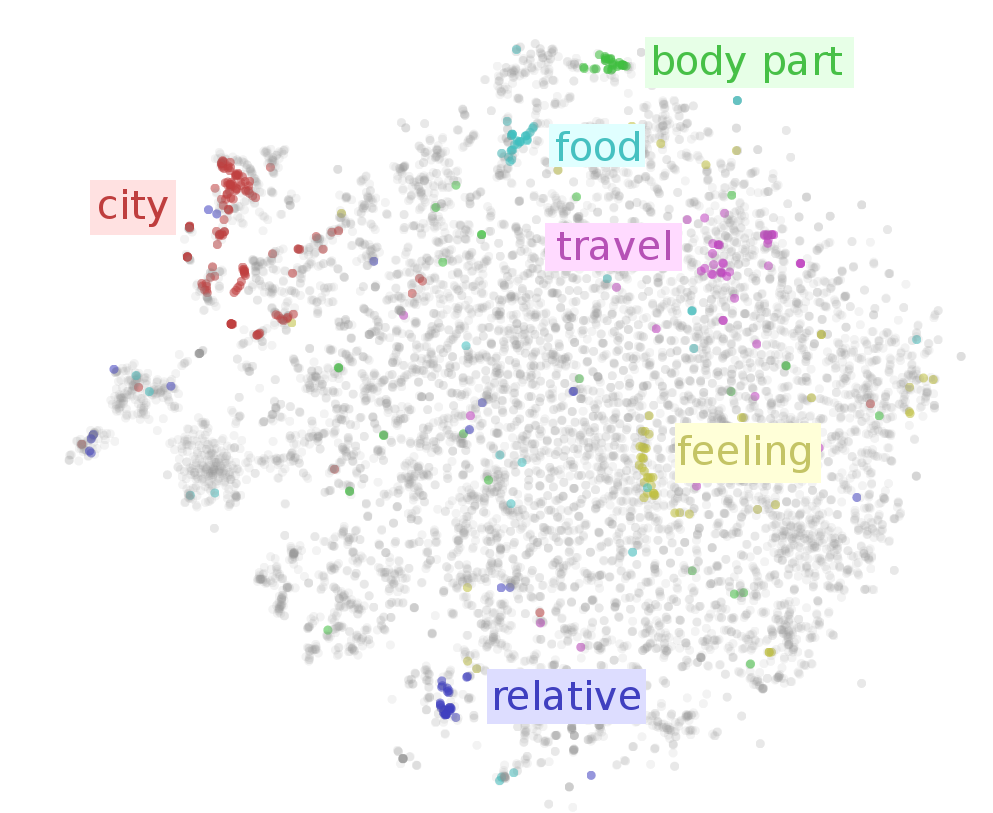

How can we extract sentance embedding (not word one): https://engineering.talkdesk.com/what-are-sentence-embeddings-and-why-are-they-useful-53ed370b3f35

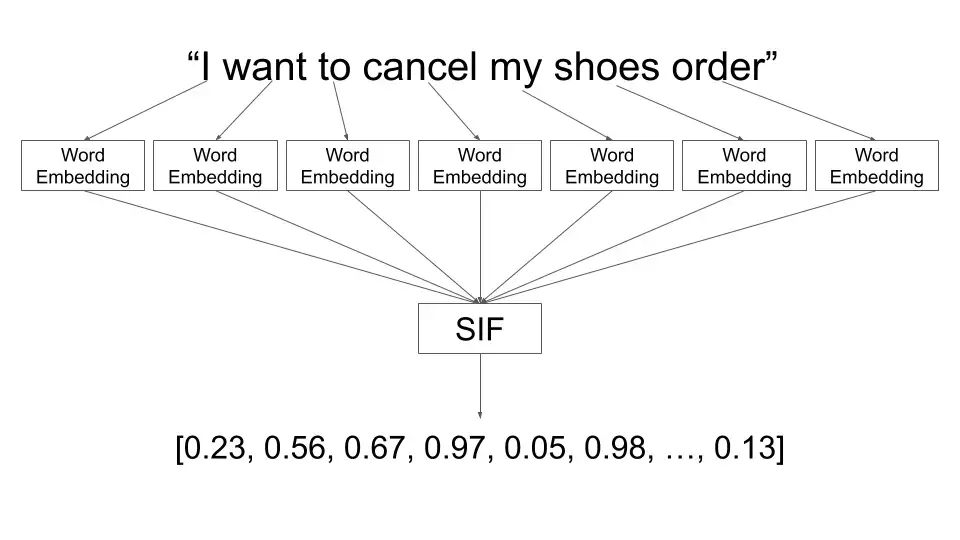

Advantages:
- Are not dependent on current corpus - reduce overfitting and increase robusteness
- Take into account conext 
- Current SOTA for sentance Vectorization 
- ...

Disadvantages:
- In most cases require GPU and more computational resources 
- Hardly explainable
- ...

TODO: Add your thoughts to Advantages/Disadvantages

In [27]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.8 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [28]:
# TODO: Try other spacy models
spacy_nlp = spacy.load('en_core_web_lg')

In [29]:
# TODO: Explore spacy_doc more. What fields can you find there (read official Docs)
spacy_doc = spacy_nlp(df['title'].iloc[1])

In [30]:
print(
    f"Word : {spacy_doc[3]}\n"
    f"Vectorization: {spacy_doc[3].vector}"
)

Word : accept
Vectorization: [-1.2043   -0.64174   0.023952 -0.86397   0.65102   6.4086   -0.43359
  2.898    -5.706    -3.8502    5.6369    0.9742   -6.123     1.3867
  1.1591    2.1727   -0.13604  -2.0005    0.72829   0.6602   -2.3399
 -6.3409   -3.293     2.6541    0.25034   0.77346  -0.015012  0.63865
 -3.51      1.015     5.2983   -1.3421   -1.4947   -0.57899  -0.54777
  1.6737    0.54918  -1.0954    3.6285    4.9579   -4.3719    3.7141
  0.35932   3.9965   -4.4139   -0.17062   5.0334   -2.3586   -3.3381
  2.0836   -1.8228    1.7629   -1.4121   -5.5236   -2.1964   -1.451
 -0.79034   2.1484   -1.074     4.3066    5.1646   -1.6272   -0.048835
  0.25858   4.6833    1.0665   -1.6718   -3.5821    2.031     4.7402
 -1.6128   -1.7114   -0.48749  -2.0487   -1.4564    3.8387   -0.39081
  4.26     -1.7288    0.084857 -5.2002    1.8084    2.2857    1.3991
  0.079649 -2.0074    2.7641   -1.9222   -0.34447   2.1323    5.6094
 -0.14864  -0.16585  -1.6315    4.3496    1.0503    1.1893   -1.7869


In [31]:
print(
    f"Text : {spacy_doc}\n"
    f"Vectorization: {spacy_doc.vector}"
)

Text : U.S. military to accept transgender recruits on Monday: Pentagon
Vectorization: [-1.4419098   2.333012   -2.0302525   2.1737072   3.8636289   1.1787727
  0.24634902  1.6456709  -1.323744   -1.5893221   1.7309109   2.3810363
 -4.152365    0.59767413 -0.41175598  2.263166    2.5466912  -1.3361989
 -0.6237039  -0.8527702   0.23810203 -3.3882613   1.5956199   0.58893
  2.5552077  -0.77493805 -1.2420542   1.4099209  -1.838369   -0.77410513
  0.10948737  0.40107894 -1.1118151  -1.730406   -0.40813288 -2.4930186
 -0.23138304 -0.23291802 -0.86333305  1.6781151   1.1301205   0.8376549
  0.17182697  0.599145   -2.472589   -0.264782    2.5121498  -1.3549932
 -0.34908897  3.942492   -0.67503595  0.258276   -1.9288241  -5.154185
 -1.7360522   1.443761   -0.20464401 -0.17268296  0.6267451   1.6993821
 -1.3735391   0.10007596 -0.7624536   1.4414771   4.09579     0.36264998
 -1.6023979  -2.6676493  -1.118904    1.9057581  -1.0480089  -1.3108575
 -1.4945599   0.301369   -0.434199    1.8647768  -

In [35]:
# TODO: Try other SentenceTransformer models. Try multi-lingual models
sent_tr = SentenceTransformer('all-MiniLM-L6-v2',)

In [36]:
print(
    f"Text : {df['title'].iloc[1]}\n"
    f"Vectorization: {sent_tr.encode([df['title'].iloc[1]])[0]}"
)

Text : U.S. military to accept transgender recruits on Monday: Pentagon
Vectorization: [-4.10019606e-02 -6.35424852e-02 -1.85647514e-02  1.97503753e-02
 -1.85067412e-02 -9.20545682e-03  6.33931533e-02 -5.11556827e-02
 -4.00203690e-02 -4.60175099e-03 -2.02232990e-02  2.12608743e-02
  3.47362310e-02  6.74327686e-02  8.16419646e-02  5.98109793e-03
  3.71713750e-02  2.68850569e-02  8.42864066e-02  5.09826019e-02
 -1.65796019e-02 -9.39757600e-02  8.14584736e-03  1.02734482e-02
 -8.77536833e-03 -7.57154450e-02  1.20381834e-02  1.87517086e-03
 -1.30369022e-01  6.23163246e-02 -6.52768984e-02  3.93375456e-02
 -7.07048997e-02  3.22036631e-02  6.19631261e-03  5.13774045e-02
  1.98817849e-02 -4.38232422e-02  6.50472045e-02  5.76738678e-02
 -9.60831791e-02 -7.87050650e-02  1.01646550e-01  6.18104376e-02
 -1.07194735e-02 -8.30625743e-03 -1.72314383e-02 -3.75427566e-02
 -1.27877044e-02 -3.79788578e-02  1.64839387e-01 -9.16555151e-02
  3.98485996e-02  3.01890429e-02 -4.23896406e-03  6.90304115e-03
  4

## [Sentence Similarity](https://www.sbert.net/docs/usage/semantic_textual_similarity.html)

How to find simmiliar sentances in text corpus ?

1. Extract sentance embeddings
2. Compute pair-wise [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)
3. Find biggest value of cosine similarity among other texts in text corpus for a particular text

In [37]:
sebert_embeddings = sent_tr.encode(df['title'].to_list(), convert_to_tensor=True)

In [38]:
cosine_scores = util.cos_sim(sebert_embeddings, sebert_embeddings).detach().cpu().numpy()

In [39]:
text_id = 1002
nearest_text_id = np.argsort(cosine_scores[text_id])[-2]

print(
    f"Text: {df['title'].iloc[text_id]}\n"
    f"`Nearest` Text: {df['title'].iloc[nearest_text_id]}\n"
)

Text: House narrowly passes measure paving way for Trump tax cuts
`Nearest` Text: Trump tax cut plan gains momentum after U.S. budget vote



<a id='Validation'></a>
# [Validation](https://scikit-learn.org/stable/modules/cross_validation.html)

Another Important Link - https://github.com/udsclub/udscourse/blob/master/lectures/3.0%20-%20Evaluating%20models.%20Validation.%20Metrics.ipynb

Model evaluation is not just the end point of our machine learning pipeline. Before we handle any data, we want to plan ahead and use techniques and metrics that are suited for our purposes.

### <a name="1"></a> 1. Model Evaluation Applications
Let's start with a question: **"Why do we care about performance estimates at all?"**

<a name="1.1"></a>**Generalization performance** - We want to estimate the predictive performance of our model on future (unseen) data.
- Ideally, the estimated performance of a model tells how well it performs on unseen data – making predictions on future data is often the main problem we want to solve.

<a name="1.2"></a>**Model selection** - We want to increase the predictive performance by tweaking the learning algorithm and selecting the best performing model from a given hypothesis space.
- Typically, machine learning involves a lot of experimentation. Running a learning algorithm over a training dataset with different hyperparameter settings and different features will result in different models. Since we are typically interested in selecting the best-performing model from this set, we need to find a way to estimate their respective performances in order to rank them against each other.

<a name="1.3"></a>**Algorithm selection** - We want to compare different ML algorithms, selecting the best-performing one.
- We are usually not only experimenting with the one single algorithm that we think would be the “best solution” under the given circumstances. More often than not, we want to compare different algorithms to each other, oftentimes in terms of predictive and computational performance.

Although these three sub-tasks have all in common that we want to estimate the performance of a model, they all require different approaches. 

This tutorial will focus on **supervised learning**, a subcategory of machine learning where our target values are known in our available dataset.

### <a name="2"></a>2. Model Evaluation Techniques
#### <a name="2.1"></a>Holdout method (simple train/test split)
The holdout method is the simplest model evaluation technique. We take our labeled dataset and split it randomly into two parts: A **training set** and a **test set**
<img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part1/testing_01.png" width="500">
Then, we fit a model to the training data and predict the labels of the test set.
<img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part1/testing_02.png" width="500">
And the fraction of correct predictions constitutes our estimate of the prediction accuracy.
<img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part1/testing_03.png" width="500">
We really don’t want to train and evaluate our model on the same training dataset, since it would introduce **overfitting**. In other words, we can’t tell whether the model simply memorized the training data or not, or whether it generalizes well to new, unseen data.

##### Pros:
    + Simple
    + Fast

##### Cons:
    - Not so precise estimate of out-of-sample performance comparing to more advanced techniques

### Be aware.

As it was said, you want your validation to mimic your test set as close as possible. And you can make a fair assumprion (that is not always true), that distribution of target on train and not seen data is the same. Then you have to use stratification. Stratification ensures stable distributions across split. That is more than just useful if:

    + Dataset is small
    + Dataset is unbalanced (target average for binary classification this means average target close to 0 or to 1)
    + You have multiclassification task

See example below.

In [40]:
X_train, X_test, _, _ = train_test_split(df, df["target"], test_size=0.2, random_state=42, shuffle=True)

In [41]:
print(f"Train and Test intersection : {set(X_train.index) & set(X_test.index)}")

Train and Test intersection : set()


In [42]:
print("Test Target distribution")
X_test.target.value_counts(normalize=True)

Test Target distribution


0    0.517817
1    0.482183
Name: target, dtype: float64

In [43]:
print("Train Target distribution")
X_test.target.value_counts(normalize=True)

Train Target distribution


0    0.517817
1    0.482183
Name: target, dtype: float64

### <a name="2.2"></a>K-fold Cross-validation
K-fold Cross-validation is probably the most common technique for model evaluation and model selection. 
- We split the dataset into *K* parts and iterate over a dataset set *K* times
- In each round one part is used for validation, and the remaining *K-1* parts are merged into a training subset for model evaluation
- We compute the cross-validation performance as the arithmetic mean over the *K* performance estimates from the validation sets.
<img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/kfold.png" width="500">

##### Pros:
    + Better estimate of out-of-sample performance than simple train/test split

##### Cons:
    - Runs "K" times slower than simple train/test split

If we have **little data** and **enough time**, it's better to always do cross-validation for a more precise estimate of performance.

In [44]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(df, df["target"])]

X_train_fold_0, X_test_fold_0 = df.iloc[folds_train_test_ids[0][0]], df.iloc[folds_train_test_ids[0][1]]

In [45]:
print(f"Train and Test intersection : {set(X_train_fold_0.index) & set(X_test_fold_0.index)}")

Train and Test intersection : set()


In [46]:
print("Test Target distribution")
X_test_fold_0.target.value_counts(normalize=True)

Test Target distribution


0    0.52294
1    0.47706
Name: target, dtype: float64

In [47]:
print("Train Target distribution")
X_train_fold_0.target.value_counts(normalize=True)

Train Target distribution


0    0.522997
1    0.477003
Name: target, dtype: float64

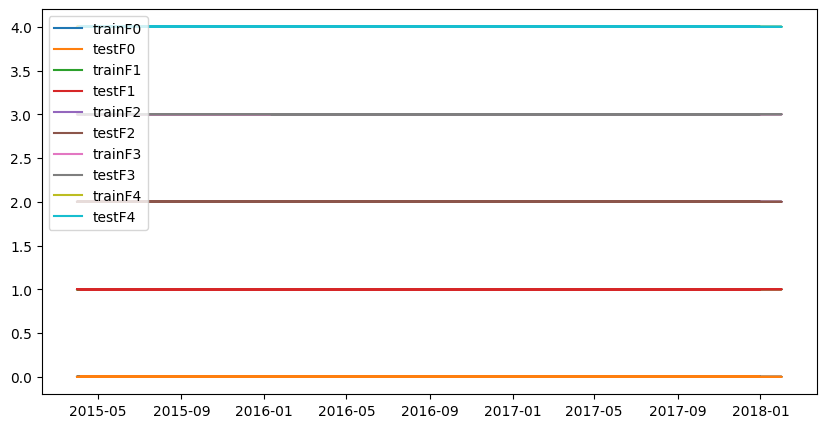

In [48]:
plt.figure(figsize=(10,5))
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    plt.plot(df["date"].iloc[train_ids], [fold_id]*len(train_ids), label=f"trainF{fold_id}")
    plt.plot(df["date"].iloc[test_ids], [fold_id]*len(test_ids), label=f"testF{fold_id}")
    
plt.legend()
plt.show()

In [49]:
print(
    f"Train Date Min = {X_train_fold_0['date'].min()} Max = {X_train_fold_0['date'].max()}\n"
    f"Test Date Min = {X_test_fold_0['date'].min()} Max = {X_test_fold_0['date'].max()}"
)

Train Date Min = 2015-03-31 00:00:00 Max = 2018-02-01 00:00:00
Test Date Min = 2015-03-31 00:00:00 Max = 2018-02-01 00:00:00


Doing **Time validation** in correct way is very important. Suppose you have a task to predict Wikipedia page viewers as in on of previous Kaggle competitions (https://www.kaggle.com/c/web-traffic-time-series-forecasting). What are possible ways to do a validation? Again, it is best to mimic split made by organizers and they split this by date. All before January, 1st, 2017 went to train, all after that date (2 months) - to test. The correct way to perform a split is with **sliding window**(credit for picture to Uber blogpost):
 

<img src="http://eng.uber.com/wp-content/uploads/2018/01/image3-4.png" width="500">

Another approach 

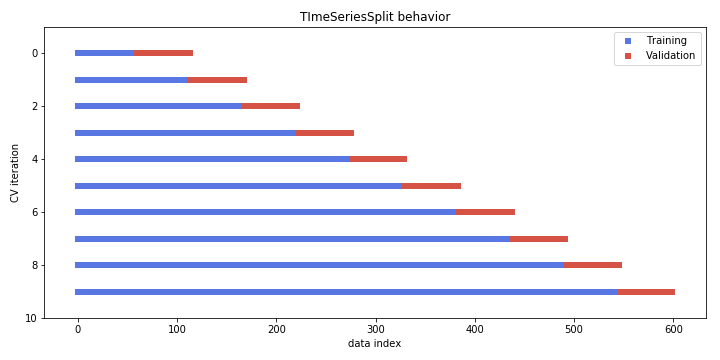


In [50]:
df_ts = df[~df["date"].isna()].sort_values("date").reset_index(drop=True)

timesplit = TimeSeriesSplit(n_splits=5)
folds_ts_train_test_ids = [el for el in timesplit.split(df_ts, df_ts["target"])]

X_train_fold_ts_0, X_test_fold_ts_0 = df_ts.iloc[folds_ts_train_test_ids[0][0]], df_ts.iloc[folds_ts_train_test_ids[0][1]]

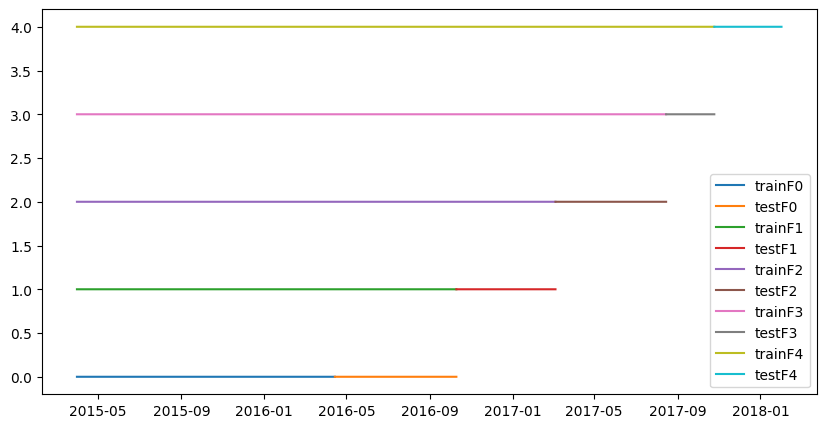

In [51]:
plt.figure(figsize=(10,5))
for fold_id, (train_ids, test_ids) in enumerate(folds_ts_train_test_ids):
    plt.plot(df_ts["date"].iloc[train_ids], [fold_id]*len(train_ids), label=f"trainF{fold_id}")
    plt.plot(df_ts["date"].iloc[test_ids], [fold_id]*len(test_ids), label=f"testF{fold_id}")
    
plt.legend()
plt.show()

In [52]:
print(f"Train and Test intersection : {set(X_train_fold_ts_0.index) & set(X_test_fold_ts_0.index)}")

Train and Test intersection : set()


In [53]:
print(
    f"Train Date Min = {X_train_fold_ts_0['date'].min()} Max = {X_train_fold_ts_0['date'].max()}\n"
    f"Test Date Min = {X_test_fold_ts_0['date'].min()} Max = {X_test_fold_ts_0['date'].max()}"
)

Train Date Min = 2015-03-31 00:00:00 Max = 2016-04-14 00:00:00
Test Date Min = 2016-04-14 00:00:00 Max = 2016-10-10 00:00:00


In [54]:
print("Test Target distribution")
X_test_fold_ts_0.target.value_counts(normalize=True)

Test Target distribution


0    0.726373
1    0.273627
Name: target, dtype: float64

In [55]:
print("Train Target distribution")
X_train_fold_ts_0.target.value_counts(normalize=True)

Train Target distribution


0    0.820259
1    0.179741
Name: target, dtype: float64

## Group Validation

Group can refer to user id, store, city or any other entity. Another type of validation construction - is by group. Suppose you have a task to build a model to predict a weather in cities based on previous dates. Then if you know that in test set there are only new unseen cities, you should split yor dataset on train and validation such as there is no records for any city present in both train and validation.

TODO: Try to build Group Validation on `subject` feature. Use https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html

## [ROC-AUC](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

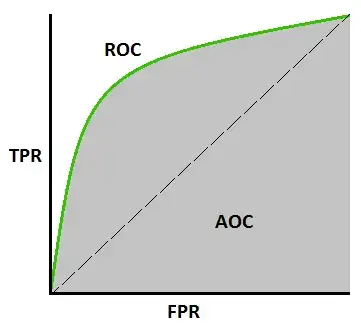

Examples of predicted probability distributions for different ROC-AUC cases

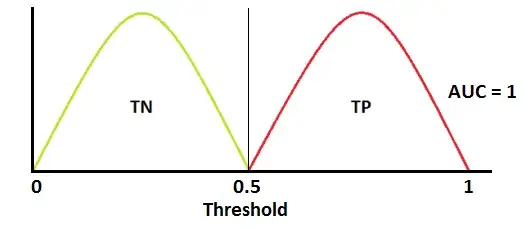

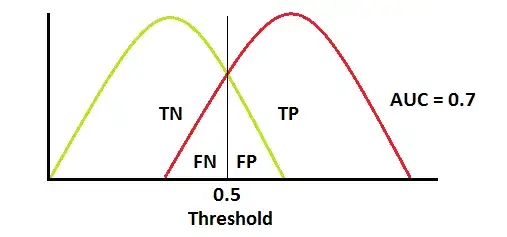

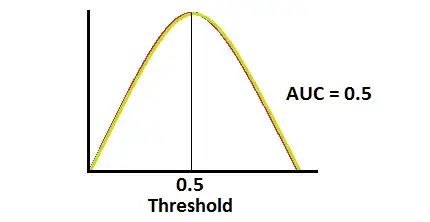

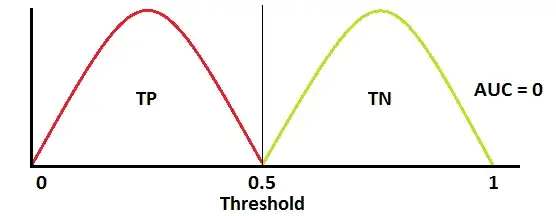

## [Linear Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 

More on the next lecture

In [56]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    model = Pipeline([
        ("vectorizer", CountVectorizer()),
        ("lof_reg", LogisticRegression())
    ])
    model.fit(df["clean_title"].iloc[train_ids], df["target"].iloc[train_ids])
    # First channel refers to Negative class and second channel refers to Postive class
    fold_train_preds = model.predict_proba(df["clean_title"].iloc[train_ids])[:,1]
    fold_test_preds = model.predict_proba(df["clean_title"].iloc[test_ids])[:,1]
    fold_train_targets = df["target"].iloc[train_ids].values
    fold_test_targets = df["target"].iloc[test_ids].values
    print(
        f"Fold {fold_id}\n"
        f"Train Roc Auc score = {roc_auc_score(fold_train_targets, fold_train_preds)}\n"
        f"Test Roc Auc score = {roc_auc_score(fold_test_targets, fold_test_preds)}"
    )
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)

print(f"OOF Test Score: {roc_auc_score(all_test_targets, all_test_preds)}")
print(f"OOF Train Score: {roc_auc_score(all_train_targets, all_train_preds)}")

/Users/tylerdurden/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 0
Train Roc Auc score = 0.9982706310231835
Test Roc Auc score = 0.9893539329417174


/Users/tylerdurden/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1
Train Roc Auc score = 0.9983057599083007
Test Roc Auc score = 0.9881654251706361
Fold 2
Train Roc Auc score = 0.9982004477334583
Test Roc Auc score = 0.9896723463856965


/Users/tylerdurden/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3
Train Roc Auc score = 0.9982817242373203
Test Roc Auc score = 0.9895357065153189


/Users/tylerdurden/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4
Train Roc Auc score = 0.9982786079967951
Test Roc Auc score = 0.9890791354115416
OOF Test Score: 0.9891602078668185
OOF Train Score: 0.9982670109833418


<a id='TODO'></a>
## TODO:
- Take all previous Vectorization algoritmes (CountVectorizer, TfidfVectorizer, spacy embeddings, SentenceTransformer(you will ned GPU for it))
- Take Linear Model code (Cross Validation + Some Vectorization Algorithm + Logistic Regression + Roc Auc score)
- Use 3 following datasets:
    - https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/code?datasetId=572515
    - ../data/propaganda_detection_our_data/
    - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
- Try to build best model

Note:
- Try to use different text columns (I have used only title)
- You can try check your model robustness by training it on this dataset https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/code?datasetId=572515 and trying to test on other fake news datasets https://www.kaggle.com/datasets?search=fake+news

<a id='Homework'></a>
# Homework

Thoery:
- Take a look at all links 
- Read and analyze all theory `TODO`s

Practice:
- Do all practical `TODO`s
- Do Last Big [TODO](#TODO) - This one is the most important
Advanced practice:
- Arithmetic operations can work pretty descent with word embeddings. Read this article - https://medium.com/data-from-the-trenches/arithmetic-properties-of-word-embeddings-e918e3fda2ac and try to use Word2Vec in order to play with it in the code 